In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import module
import sys
sys.path.append('/content/drive/MyDrive')
from preprocessing import FederatedDataBuilder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



######################################################################
# Running Task Arithmetic Experiment
######################################################################


Federated Learning with Task Arithmetic
Device: cuda
Clients: 100, Sampling: 0.1
Rounds: 30, Local Epochs: 4
Sparsity: 0.5, Learning Rate: 0.1

Preparing data...
Creating IID partition for 100 clients...
Initializing global model...
Loading DINO backbone...


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


✓ DINO loaded
Initial accuracy: 0.79% (expected ~1% for random init)

Starting training (10 clients per round)...

Round 1/30
Selected clients: [78 44 87 70 93]...

Client 1/10 (ID: 78):
  Local samples: 450
  Computing Fisher sensitivity...
  Calibrating masks (sparsity=0.5)...
  Active params: 19250/38500 (50.00%)
  Training for 4 epochs...
    Epoch 1: loss=14.6403
    Epoch 2: loss=14.6141
    Epoch 3: loss=14.0571
    Epoch 4: loss=13.5539

Aggregating 10 models...

Round 1 Results:
  Avg Train Loss: 14.3966
  Test Loss: 13.8076
  Test Accuracy: 0.91%

Round 2/30
Selected clients: [49 83 63 29 12]...

Client 1/10 (ID: 49):
  Local samples: 450
  Computing Fisher sensitivity...
  Calibrating masks (sparsity=0.5)...
  Active params: 19250/38500 (50.00%)
  Training for 4 epochs...
    Epoch 1: loss=13.8378
    Epoch 2: loss=13.6378
    Epoch 3: loss=13.0444
    Epoch 4: loss=12.6934

Aggregating 10 models...

Round 2 Results:
  Avg Train Loss: 13.2292
  Test Loss: 12.7540
  Test Accu

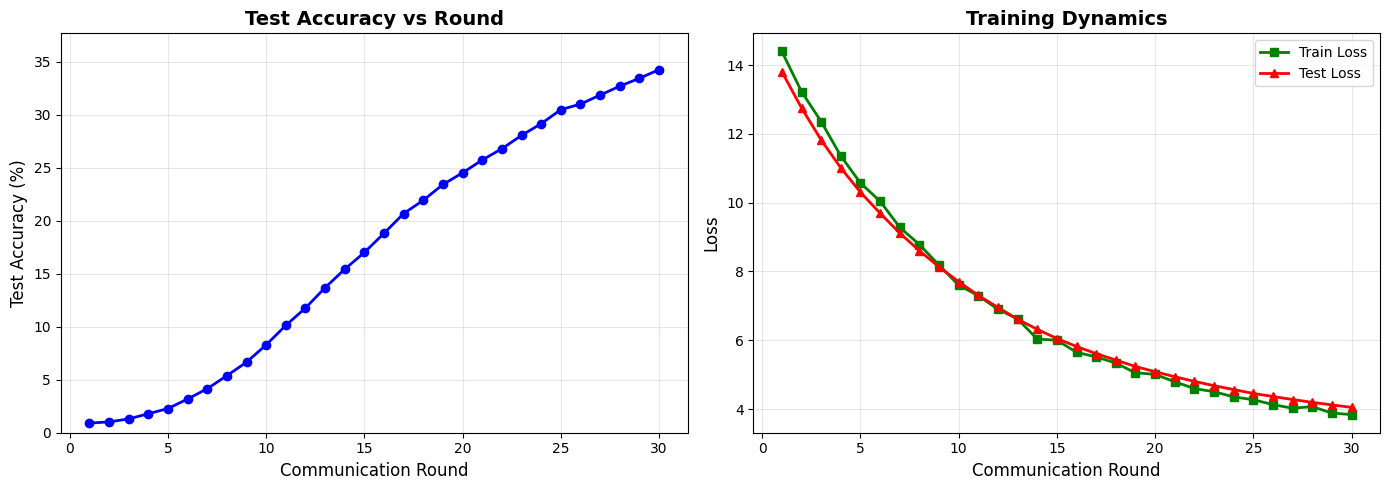

In [11]:
"""
Task Arithmetic 联邦学习 - 完全修复版本
解决了所有已知问题
"""
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
from torch.utils.data import DataLoader, Subset
from preprocessing import FederatedDataBuilder

# ============================================================
# 修复后的SparseSGDM
# ============================================================
class SparseSGDM(optim.SGD):
    """修复版的稀疏SGD with Momentum"""
    def __init__(self, params, lr=0.001, momentum=0.9, weight_decay=0.0, dampening=0, masks=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)
        self.masks = masks

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                d_p = p.grad

                # 应用mask到梯度
                if self.masks is not None and p in self.masks:
                    d_p = d_p.mul(self.masks[p])

                # Weight decay
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])

                # Momentum
                if group['momentum'] != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(group['momentum']).add_(d_p, alpha=1 - group['dampening'])
                    d_p = buf

                # 再次应用mask（防止momentum引入被mask的更新）
                if self.masks is not None and p in self.masks:
                    d_p = d_p.mul(self.masks[p])

                # 更新参数
                p.add_(d_p, alpha=-group['lr'])

        return loss


# ============================================================
# Fisher敏感度和掩码校准
# ============================================================
def compute_fisher_sensitivity_head(model, dataloader, criterion, device, num_batches=5):
    """只对head计算Fisher敏感度"""
    sensitivity = {}
    model.eval()

    for p in model.head.parameters():
        if p.requires_grad:
            sensitivity[p] = torch.zeros_like(p.data)

    processed = 0
    for inputs, labels in dataloader:
        if processed >= num_batches:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        for p in model.head.parameters():
            if p.requires_grad and p.grad is not None:
                sensitivity[p] += p.grad.data ** 2

        processed += 1

    for p in sensitivity:
        sensitivity[p] /= processed

    return sensitivity


def calibrate_masks(sensitivity_scores, sparsity_ratio=0.1, keep_least_sensitive=True):
    """校准掩码"""
    all_scores = torch.cat([s.view(-1) for s in sensitivity_scores.values()])
    num_params = all_scores.numel()
    k = int(num_params * sparsity_ratio)

    if keep_least_sensitive:
        threshold = torch.kthvalue(all_scores, k).values.item()
        masks = {p: (score <= threshold).float() for p, score in sensitivity_scores.items()}
    else:
        threshold = torch.kthvalue(all_scores, num_params - k).values.item()
        masks = {p: (score >= threshold).float() for p, score in sensitivity_scores.items()}

    return masks


# ============================================================
# 模型定义
# ============================================================
GLOBAL_DINO_BACKBONE = None

def get_dino_backbone():
    global GLOBAL_DINO_BACKBONE
    if GLOBAL_DINO_BACKBONE is None:
        print("Loading DINO backbone...")
        GLOBAL_DINO_BACKBONE = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        print("✓ DINO loaded")
    return GLOBAL_DINO_BACKBONE


class DINOCIFAR100(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = get_dino_backbone()
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.head = nn.Linear(384, num_classes)
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        return self.head(features)


# ============================================================
# FedAvg聚合
# ============================================================
def fed_avg_aggregate(global_model, local_weights, client_sample_counts):
    global_dict = copy.deepcopy(global_model.state_dict())
    total_samples = sum(client_sample_counts)

    for k in global_dict.keys():
        if 'num_batches_tracked' not in k and 'backbone' not in k:
            global_dict[k] = global_dict[k] * 0.0

    for i in range(len(local_weights)):
        ratio = client_sample_counts[i] / total_samples
        weights = local_weights[i]
        for k in global_dict.keys():
            if 'num_batches_tracked' not in k and 'backbone' not in k:
                global_dict[k] += weights[k] * ratio

    return global_dict


# ============================================================
# 本地训练（Task Arithmetic）
# ============================================================
def local_train_task_arithmetic(model, train_dataset, client_indices, device,
                                 sparsity_ratio=0.1, local_epochs=4, lr=0.1, verbose=False):
    model.train()
    model.to(device)

    local_sub = Subset(train_dataset, list(client_indices))
    local_loader = DataLoader(local_sub, batch_size=128, shuffle=True, num_workers=0)
    criterion = nn.CrossEntropyLoss()

    if verbose:
        print(f"  Local samples: {len(local_sub)}")
        print(f"  Computing Fisher sensitivity...")

    # 计算Fisher敏感度（只对head）
    sensitivity = compute_fisher_sensitivity_head(model, local_loader, criterion, device, num_batches=5)

    if verbose:
        print(f"  Calibrating masks (sparsity={sparsity_ratio})...")

    # 校准掩码
    masks = calibrate_masks(sensitivity, sparsity_ratio=sparsity_ratio, keep_least_sensitive=True)

    # 统计
    total_params = sum(p.numel() for p in model.head.parameters())
    active_params = sum((masks[p] > 0).sum().item() for p in masks)
    actual_sparsity = active_params / total_params

    if verbose:
        print(f"  Active params: {active_params}/{total_params} ({actual_sparsity:.2%})")
        print(f"  Training for {local_epochs} epochs...")

    # 稀疏微调
    model.train()
    optimizer = SparseSGDM(model.head.parameters(), lr=lr, momentum=0.9, masks=masks)

    losses = []
    for epoch in range(local_epochs):
        epoch_losses = []
        for inputs, labels in local_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.head.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_losses.append(loss.item())

        epoch_loss = np.mean(epoch_losses)
        losses.append(epoch_loss)
        if verbose:
            print(f"    Epoch {epoch+1}: loss={epoch_loss:.4f}")

    return model.state_dict(), len(local_sub), np.mean(losses)


# ============================================================
# 评估函数
# ============================================================
def evaluate(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total


# ============================================================
# 主联邦训练循环
# ============================================================
def run_federated_task_arithmetic(rounds=50, num_clients=100, sampling_rate=0.1,
                                   sparsity=0.1, local_epochs=4, lr=0.1, verbose_client=False):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n{'='*70}")
    print(f"Federated Learning with Task Arithmetic")
    print(f"{'='*70}")
    print(f"Device: {DEVICE}")
    print(f"Clients: {num_clients}, Sampling: {sampling_rate}")
    print(f"Rounds: {rounds}, Local Epochs: {local_epochs}")
    print(f"Sparsity: {sparsity}, Learning Rate: {lr}")
    print(f"{'='*70}\n")

    # 数据准备
    print("Preparing data...")
    builder = FederatedDataBuilder(K=num_clients)
    dict_users = builder.get_iid_partition()
    test_loader = DataLoader(builder.test_dataset, batch_size=256, shuffle=False, num_workers=0)

    # 初始化全局模型
    print("Initializing global model...")
    global_model = DINOCIFAR100(num_classes=100).to(DEVICE)

    # 检查初始性能
    init_loss, init_acc = evaluate(global_model, test_loader, DEVICE)
    print(f"Initial accuracy: {init_acc:.2f}% (expected ~1% for random init)\n")

    history = {"accuracy": [], "loss": [], "train_loss": [], "round": []}

    # 联邦训练
    m = max(int(sampling_rate * num_clients), 1)
    print(f"Starting training ({m} clients per round)...\n")

    for r in range(rounds):
        print(f"{'='*70}")
        print(f"Round {r+1}/{rounds}")
        print(f"{'='*70}")

        local_weights = []
        local_counts = []
        local_losses = []

        # 随机选择客户端
        selected_clients = np.random.choice(range(num_clients), m, replace=False)
        print(f"Selected clients: {selected_clients[:5]}..." if m > 5 else f"Selected: {selected_clients}")

        for idx, client_id in enumerate(selected_clients):
            if verbose_client or idx == 0:  # 只详细打印第一个客户端
                print(f"\nClient {idx+1}/{m} (ID: {client_id}):")
                verbose = True
            else:
                verbose = False

            # 深拷贝全局模型
            local_model = copy.deepcopy(global_model)

            # 本地训练
            w, count, train_loss = local_train_task_arithmetic(
                local_model,
                builder.train_dataset,
                dict_users[client_id],
                DEVICE,
                sparsity_ratio=sparsity,
                local_epochs=local_epochs,
                lr=lr,
                verbose=verbose
            )

            local_weights.append(w)
            local_counts.append(count)
            local_losses.append(train_loss)

        # FedAvg聚合
        print(f"\nAggregating {len(local_weights)} models...")
        global_weights = fed_avg_aggregate(global_model, local_weights, local_counts)
        global_model.load_state_dict(global_weights, strict=False)

        # 全局评估
        test_loss, test_acc = evaluate(global_model, test_loader, DEVICE)
        avg_train_loss = np.mean(local_losses)

        history["accuracy"].append(test_acc)
        history["loss"].append(test_loss)
        history["train_loss"].append(avg_train_loss)
        history["round"].append(r + 1)

        print(f"\n{'='*70}")
        print(f"Round {r+1} Results:")
        print(f"  Avg Train Loss: {avg_train_loss:.4f}")
        print(f"  Test Loss: {test_loss:.4f}")
        print(f"  Test Accuracy: {test_acc:.2f}%")
        print(f"{'='*70}\n")

        # 早停检查
        if r >= 5 and test_acc < 2:
            print("⚠️  WARNING: Accuracy still < 2% after 5 rounds!")
            print("   This suggests a fundamental problem. Consider debugging.")

    # 最终结果
    print(f"\n{'='*70}")
    print(f"Training Complete!")
    print(f"{'='*70}")
    print(f"Initial Accuracy: {init_acc:.2f}%")
    print(f"Final Accuracy: {history['accuracy'][-1]:.2f}%")
    print(f"Best Accuracy: {max(history['accuracy']):.2f}%")
    print(f"{'='*70}\n")

    return history, global_model


# ============================================================
# 主程序
# ============================================================
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # 单个实验
    print("\n" + "#"*70)
    print("# Running Task Arithmetic Experiment")
    print("#"*70 + "\n")

    history, model = run_federated_task_arithmetic(
        rounds=30,
        num_clients=100,
        sampling_rate=0.1,
        sparsity=0.5,
        local_epochs=4,
        lr=0.1,
        verbose_client=False  # 设为True可以看到所有客户端的详细信息
    )

    # 绘图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history['round'], history['accuracy'], 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Communication Round', fontsize=12)
    ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax1.set_title('Test Accuracy vs Round', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, max(history['accuracy']) * 1.1])

    ax2.plot(history['round'], history['train_loss'], 'g-s', label='Train Loss', linewidth=2, markersize=6)
    ax2.plot(history['round'], history['loss'], 'r-^', label='Test Loss', linewidth=2, markersize=6)
    ax2.set_xlabel('Communication Round', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training Dynamics', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('task_arithmetic_results.png', dpi=150, bbox_inches='tight')
    print("\n✓ Figure saved: task_arithmetic_results.png\n")
    plt.show()

In [12]:
"""
联邦Task Arithmetic诊断脚本 (最终版)
用于排查为什么模型精度极低(~1%)

使用 DINOCIFAR100 模型类
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np

from preprocessing import FederatedDataBuilder
from taskarithmetic import compute_fisher_sensitivity, calibrate_masks

# 导入模型 - 兼容不同的命名
try:
    from fed_avg_iid import DINOCIFAR100Fixed as DINOCIFAR100
except ImportError:
    from fed_avg_iid import DINOCIFAR100


def diagnose_mask_problem(sparsity_ratio=0.1):
    """
    诊断掩码是否过于严格
    """
    print("\n" + "="*70)
    print("诊断 1: 检查掩码生成")
    print("="*70)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 准备数据
    builder = FederatedDataBuilder(K=10)
    dict_users = builder.get_iid_partition()

    # 创建模型
    model = DINOCIFAR100(num_classes=100).to(DEVICE)

    # 准备一个客户端的数据
    local_subset = Subset(builder.train_dataset, list(dict_users[0]))
    local_loader = DataLoader(local_subset, batch_size=32, shuffle=True)

    criterion = nn.CrossEntropyLoss()

    # 计算敏感度
    print(f"\n计算Fisher敏感度 (sparsity={sparsity_ratio})...")
    sensitivity_scores = compute_fisher_sensitivity(
        model, local_loader, criterion, DEVICE, num_batches=5
    )

    # 生成掩码
    masks = calibrate_masks(
        sensitivity_scores,
        sparsity_ratio=sparsity_ratio,
        keep_least_sensitive=True
    )

    # 分析掩码
    print("\n掩码统计:")
    print("-" * 70)

    total_params = 0
    frozen_params = 0
    active_params = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            mask = masks.get(param)
            if mask is not None:
                num_params = int(param.numel())
                num_active = int(mask.sum().item())
                num_frozen = num_params - num_active

                total_params += num_params
                frozen_params += num_frozen
                active_params += num_active

                active_ratio = 100 * num_active / num_params
                print(f"{name:30s} | Total: {num_params:8d} | "
                      f"Active: {num_active:8d} ({active_ratio:5.1f}%) | "
                      f"Frozen: {num_frozen:8d}")

    print("-" * 70)
    print(f"{'总计':30s} | Total: {total_params:8d} | "
          f"Active: {active_params:8d} ({100*active_params/total_params:5.1f}%) | "
          f"Frozen: {frozen_params:8d}")

    # 关键检查
    if active_params == 0:
        print("\n❌ 严重错误: 所有参数都被冻结!")
        print("   - 模型无法学习")
        print("   - 需要检查calibrate_masks实现")
        return False

    if active_params < total_params * 0.01:  # 小于1%
        print("\n⚠️  警告: 可更新参数过少!")
        print(f"   - 只有{100*active_params/total_params:.2f}%的参数可以更新")
        print("   - 建议增大sparsity_ratio")
        return False

    print("\n✓ 掩码生成正常")
    return True


def diagnose_training_step():
    """
    诊断单步训练是否正常
    """
    print("\n" + "="*70)
    print("诊断 2: 检查训练步骤")
    print("="*70)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 准备数据
    builder = FederatedDataBuilder(K=10)
    dict_users = builder.get_iid_partition()

    # 创建模型
    model = DINOCIFAR100(num_classes=100).to(DEVICE)

    # 检查backbone是否冻结
    print("\n检查backbone冻结状态:")
    backbone_params_trainable = sum(p.requires_grad for p in model.backbone.parameters())
    print(f"Backbone可训练参数数: {backbone_params_trainable}")
    if backbone_params_trainable > 0:
        print("❌ 错误: Backbone应该被完全冻结!")
        return False
    print("✓ Backbone已正确冻结")

    # 检查head
    print("\nHead参数:")
    for name, param in model.head.named_parameters():
        print(f"  {name}: requires_grad={param.requires_grad}, shape={param.shape}")

    # 准备本地数据
    local_subset = Subset(builder.train_dataset, list(dict_users[0]))
    local_loader = DataLoader(local_subset, batch_size=32, shuffle=True)

    # 获取一个batch
    inputs, targets = next(iter(local_loader))
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

    # 前向传播
    print("\n测试前向传播:")
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        print(f"  输出形状: {outputs.shape}")
        print(f"  输出范围: [{outputs.min().item():.2f}, {outputs.max().item():.2f}]")

        # 检查初始精度
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        acc = 100. * correct / targets.size(0)
        print(f"  初始精度 (随机): {acc:.2f}%")

        if acc < 0.5 or acc > 5:
            print(f"  ⚠️  警告: 初始精度异常 (期望~1%)")

    # 测试反向传播
    print("\n测试反向传播:")
    model.train()
    criterion = nn.CrossEntropyLoss()

    # 记录初始权重
    initial_weight = model.head.weight.clone()

    # 训练一步
    optimizer = torch.optim.SGD(model.head.parameters(), lr=0.1)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()

    # 检查梯度
    if model.head.weight.grad is None:
        print("  ❌ 错误: 没有计算梯度!")
        return False

    grad_norm = model.head.weight.grad.norm().item()
    print(f"  梯度范数: {grad_norm:.4f}")

    if grad_norm < 1e-6:
        print("  ⚠️  警告: 梯度过小")

    # 更新权重
    optimizer.step()

    # 检查权重是否改变
    weight_change = (model.head.weight - initial_weight).abs().max().item()
    print(f"  权重最大变化: {weight_change:.6f}")

    if weight_change < 1e-8:
        print("  ❌ 错误: 权重没有更新!")
        return False

    print("  ✓ 训练步骤正常")
    return True


def diagnose_aggregation():
    """
    诊断聚合是否正常
    """
    print("\n" + "="*70)
    print("诊断 3: 检查FedAvg聚合")
    print("="*70)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    from fed_avg_iid import fed_avg_aggregate

    # 创建全局模型
    global_model = DINOCIFAR100(num_classes=100).to(DEVICE)

    # 创建两个模拟的本地模型权重
    local_weights = []

    for i in range(2):
        local_model = DINOCIFAR100(num_classes=100).to(DEVICE)
        # 随机修改权重
        with torch.no_grad():
            local_model.head.weight += torch.randn_like(local_model.head.weight) * 0.1
        local_weights.append(local_model.state_dict())

    client_counts = [100, 100]

    # 执行聚合
    print("\n执行聚合...")
    global_weight_before = global_model.head.weight.clone()

    new_weights = fed_avg_aggregate(global_model, local_weights, client_counts)
    global_model.load_state_dict(new_weights, strict=False)

    global_weight_after = global_model.head.weight

    # 检查权重是否改变
    weight_change = (global_weight_after - global_weight_before).abs().max().item()
    print(f"全局模型权重最大变化: {weight_change:.6f}")

    if weight_change < 1e-8:
        print("❌ 错误: 聚合后全局模型权重没有改变!")
        return False

    print("✓ 聚合正常")
    return True


def test_without_task_arithmetic():
    """
    测试不使用Task Arithmetic的标准FedAvg
    """
    print("\n" + "="*70)
    print("诊断 4: 测试标准FedAvg (无Task Arithmetic)")
    print("="*70)

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 数据准备
    builder = FederatedDataBuilder(K=10)
    dict_users = builder.get_iid_partition()

    test_loader = DataLoader(
        builder.test_dataset,
        batch_size=256,
        shuffle=False
    )

    # 全局模型
    global_model = DINOCIFAR100(num_classes=100).to(DEVICE)

    from fed_avg_iid import fed_avg_aggregate, evaluate_global

    print("\n运行3轮标准FedAvg...")

    for r in range(3):
        # 选择2个客户端
        selected_clients = np.random.choice(range(10), 2, replace=False)

        local_weights = []
        client_counts = []

        for client_idx in selected_clients:
            # 本地训练
            local_model = DINOCIFAR100(num_classes=100).to(DEVICE)
            local_model.load_state_dict(global_model.state_dict())

            local_subset = Subset(builder.train_dataset, list(dict_users[client_idx]))
            local_loader = DataLoader(local_subset, batch_size=32, shuffle=True)

            optimizer = torch.optim.SGD(local_model.head.parameters(), lr=0.1, momentum=0.9)
            criterion = nn.CrossEntropyLoss()

            local_model.train()
            step_count = 0
            iterator = iter(local_loader)

            # 正确实现J=4步
            while step_count < 4:
                try:
                    inputs, targets = next(iterator)
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    optimizer.zero_grad()
                    outputs = local_model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    step_count += 1
                except StopIteration:
                    break

            local_weights.append(local_model.state_dict())
            client_counts.append(len(dict_users[client_idx]))

        # 聚合
        new_weights = fed_avg_aggregate(global_model, local_weights, client_counts)
        global_model.load_state_dict(new_weights, strict=False)

        # 评估
        test_loss, test_acc = evaluate_global(global_model, test_loader, DEVICE)
        print(f"Round {r+1}: Test Acc = {test_acc:.2f}%")

        if test_acc < 1.0:
            print("  ⚠️  精度仍然过低!")
        elif test_acc > 3.0:
            print("  ✓ 精度开始提升,基础流程正常")
            return True

    return False


def main():
    """
    运行所有诊断
    """
    print("\n" + "🔍"*35)
    print("      联邦Task Arithmetic 诊断工具")
    print("🔍"*35)

    # 诊断1: 掩码
    mask_ok = diagnose_mask_problem(sparsity_ratio=0.1)

    # 诊断2: 训练步骤
    training_ok = diagnose_training_step()

    # 诊断3: 聚合
    aggregation_ok = diagnose_aggregation()

    # 诊断4: 无TA的FedAvg
    fedavg_ok = test_without_task_arithmetic()

    # 总结
    print("\n" + "="*70)
    print("诊断总结")
    print("="*70)
    print(f"1. 掩码生成: {'✓ 正常' if mask_ok else '❌ 异常'}")
    print(f"2. 训练步骤: {'✓ 正常' if training_ok else '❌ 异常'}")
    print(f"3. FedAvg聚合: {'✓ 正常' if aggregation_ok else '❌ 异常'}")
    print(f"4. 标准FedAvg: {'✓ 正常' if fedavg_ok else '❌ 异常'}")

    print("\n" + "="*70)
    print("建议:")
    print("="*70)

    if not mask_ok:
        print("1. 检查calibrate_masks函数实现")
        print("2. 尝试更大的sparsity_ratio (如0.5)")
        print("3. 确认keep_least_sensitive逻辑正确")

    if not training_ok:
        print("1. 检查模型初始化")
        print("2. 确认backbone正确冻结")
        print("3. 调整学习率")

    if not fedavg_ok:
        print("1. 基础FedAvg就有问题,先修复它")
        print("2. 检查数据加载")
        print("3. 增加本地训练步数")

    if mask_ok and training_ok and aggregation_ok and not fedavg_ok:
        print("1. 问题可能在数据处理或模型架构")
        print("2. 尝试运行fed_avg_iid.py看是否正常")

    print("\n💡 快速修复建议:")
    print("   - 先确保标准FedAvg能work (精度>5%)")
    print("   - 再加入Task Arithmetic")
    print("   - 使用较大的sparsity_ratio开始测试")


if __name__ == "__main__":
    main()

Loading DINO backbone...


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main



Device: cuda

DIAGNOSTIC TEST

1. Loading data...
Creating IID partition for 10 clients...
   Training samples: 4500
   Test samples: 10000

2. Initializing model...

3. Model parameters:
   backbone.cls_token: shape=torch.Size([1, 1, 384]), requires_grad=False
   backbone.pos_embed: shape=torch.Size([1, 197, 384]), requires_grad=False
   backbone.patch_embed.proj.weight: shape=torch.Size([384, 3, 16, 16]), requires_grad=False
   backbone.patch_embed.proj.bias: shape=torch.Size([384]), requires_grad=False
   backbone.blocks.0.norm1.weight: shape=torch.Size([384]), requires_grad=False
   backbone.blocks.0.norm1.bias: shape=torch.Size([384]), requires_grad=False
   backbone.blocks.0.attn.qkv.weight: shape=torch.Size([1152, 384]), requires_grad=False
   backbone.blocks.0.attn.qkv.bias: shape=torch.Size([1152]), requires_grad=False
   backbone.blocks.0.attn.proj.weight: shape=torch.Size([384, 384]), requires_grad=False
   backbone.blocks.0.attn.proj.bias: shape=torch.Size([384]), requires